In [1]:
from pyspark.sql import SparkSession

In [2]:
spark: SparkSession = SparkSession.builder.appName("ExampleApp").getOrCreate()

In [3]:
df = spark.read.parquet("data/2017_StPaul_MN_Real_Estate.parquet")

In [4]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.22060612588935327
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6152231695664401
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20714585430854263


In [5]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df['LISTPRICE'])
df[['ASSESSED_TO_LIST', 'ASSESSEDVALUATION', 'LISTPRICE']].show(7)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+--------------------+-----------------+---------+
|    ASSESSED_TO_LIST|ASSESSEDVALUATION|LISTPRICE|
+--------------------+-----------------+---------+
|                 0.0|              0.0|   139900|
|                 0.0|              0.0|   210000|
|                 0.0|              0.0|   225000|
|                 0.0|              0.0|   230000|
|                 0.0|              0.0|   239900|
|1.250521050437682...|              3.0|   239900|
|              1.2E-5|              3.0|   250000|
+--------------------+-----------------+---------+
only showing top 7 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+---------

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               5000|
|   mean| 1.4302617483739894|
| stddev|  14.12890410245937|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



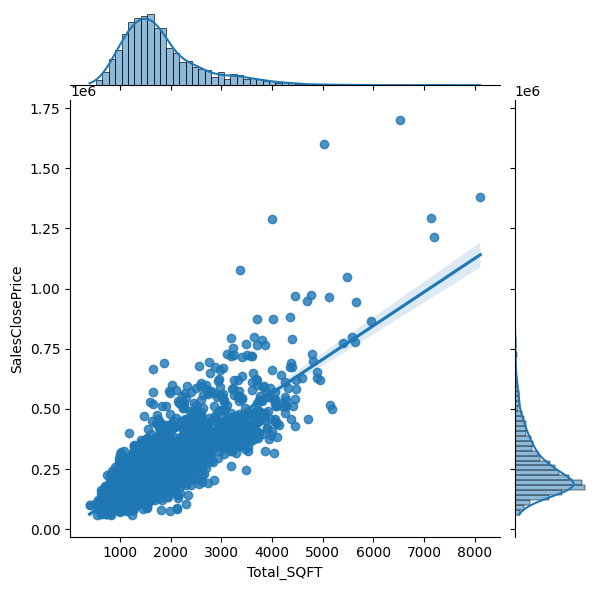

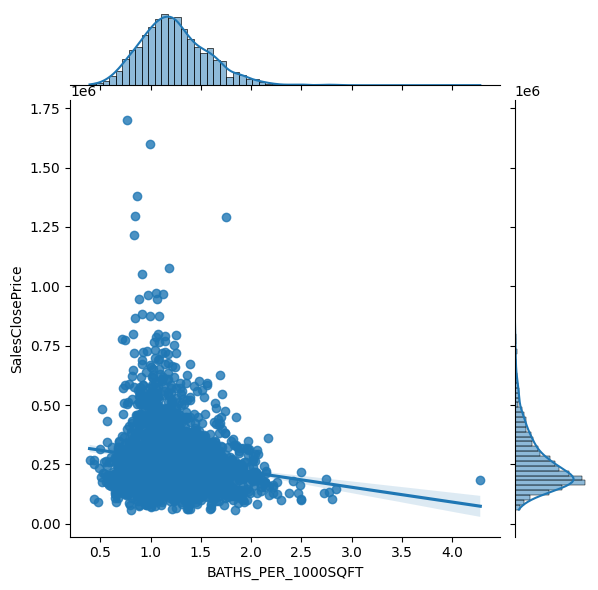

In [7]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SalesClosePrice', data=pandas_df, kind="reg")
plt.show()

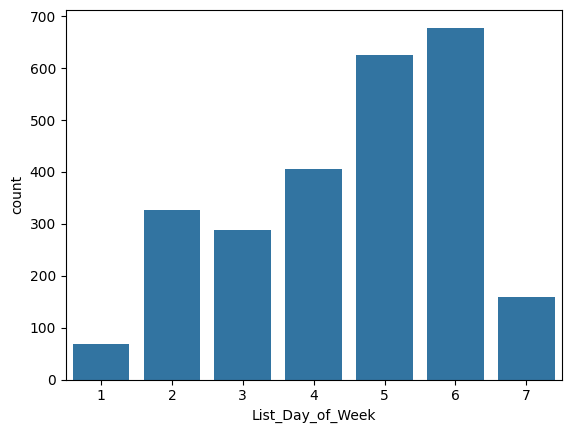

In [8]:
from pyspark.sql.functions import to_date, dayofweek


# Convert to date type
df = df.withColumn('LISTDATE', to_date('LISTDATE', 'M/d/yyyy H:mm'))
# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))
# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()
# Plot count plot of of day of week
ax = sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

## Joining On Time Components

In [9]:
# from pyspark.sql.functions import year

# # Initialize dataframes
# df = real_estate_df
# price_df = median_prices_df

# # Create year column
# df = df.withColumn('list_year', year('LISTDATE'))

# # Adjust year to match
# df = df.withColumn('report_year', (df['list_year'] - 1))

# # Create join condition
# condition = [df['CITY'] == price_df['City'], df['report_year'] == price_df['Year']]

# # Join the dataframes together
# df = df.join(price_df, on=condition, how='left')
# # Inspect that new columns are available
# df[['MedianHomeValue']].show()

In [10]:
# from pyspark.sql.functions import lag, datediff, to_date
# from pyspark.sql.window import Window

# # Cast data type
# mort_df = mort_df.withColumn('DATE', to_date('DATE'))

# # Create window
# w = Window().orderBy(mort_df['DATE'])
# # Create lag column (lag `DATE` column for 1 row)
# mort_df = mort_df.withColumn('DATE-1', lag('DATE', count=1).over(w))

# # Calculate difference between date columns
# mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))
# # Print results
# mort_df.select('Days_Between_Report').distinct().show()

In [11]:
# Import needed functions
from pyspark.sql.functions import when

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=100)

+------------------------------------------------------------------+-------------------+
|                                                 GARAGEDESCRIPTION|has_attached_garage|
+------------------------------------------------------------------+-------------------+
|                                                   Attached Garage|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|    Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                               Attached Garage, Driveway - Asphalt|                  1|
|           Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                                   Attached Garage|                  1|
|                    

In [12]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
|       Contract Pkg Required|
|                     Carport|
|                     Secured|
|             Detached Garage|
|          Driveway - Asphalt|
|                  Units Vary|
|                    Assigned|
|                   Tuckunder|
|                     Covered|
|            Insulated Garage|
|         Driveway - Concrete|
|                      Tandem|
|           Driveway - Shared|
+----------------------------+



In [13]:
print(df.count())
df.select("garage_list").show(5, truncate=False)

5000
+----------------------------------------------------------------+
|garage_list                                                     |
+----------------------------------------------------------------+
|[Attached Garage]                                               |
|[Attached Garage, Driveway - Asphalt, Garage Door Opener]       |
|[Attached Garage]                                               |
|[Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel]|
|[Attached Garage, Driveway - Asphalt, Garage Door Opener]       |
+----------------------------------------------------------------+
only showing top 5 rows



In [14]:
print(ex_df.count())
ex_df.select("ex_garage_list").show(5)

11147
+------------------+
|    ex_garage_list|
+------------------+
|   Attached Garage|
|   Attached Garage|
|Driveway - Asphalt|
|Garage Door Opener|
|   Attached Garage|
+------------------+
only showing top 5 rows



In [16]:
# from pyspark.sql.functions import lit
# ex_df = ex_df.withColumn('constant_val', lit(1))

In [26]:
# from pyspark.sql.functions import coalesce, first

# ex_df.show()

# # Pivot 
# piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

# # Join the dataframes together and fill null
# joined_df = df.join(piv_df, on='NO', how='left')

# # Columns to zero fill
# zfill_cols = piv_df.columns

# # Zero fill the pivoted values
# zfilled_df = joined_df.fillna(0, subset=zfill_cols)

In [32]:
# Import transformer
from pyspark.ml.feature import Binarizer
from pyspark.sql.functions import col

df = df.withColumn('List_Day_of_Week_Double', col('List_Day_of_Week').cast('double'))

# Create the transformer
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week_Double', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show()

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|               7|              1.0|
|               2|              0.0|
|               2|              0.0|
|               6|              1.0|
|               3|              0.0|
|               2|              0.0|
|               5|              0.0|
|               1|              0.0|
|               5|              0.0|
|               7|              1.0|
|               6|              1.0|
|               5|              0.0|
|               1|              0.0|
|               2|              0.0|
|               5|              0.0|
|               1|              0.0|
|               1|              0.0|
|               6|              1.0|
|               7|              1.0|
|               6|              1.0|
+----------------+-----------------+
only showing top 20 rows



In [37]:
sample_df["Bedrooms"]

0       2
1       3
2       3
3       3
4       3
       ..
2547    4
2548    6
2549    4
2550    4
2551    4
Name: Bedrooms, Length: 2552, dtype: int64

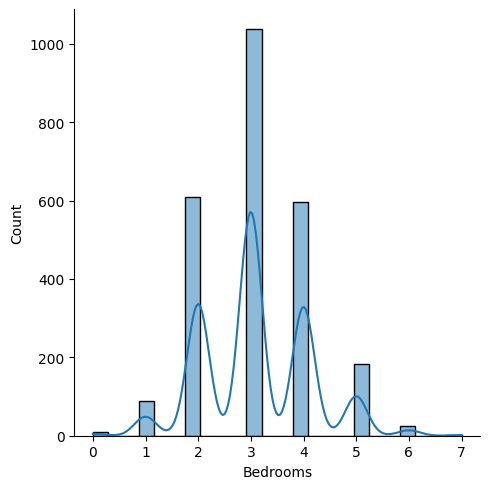

In [46]:
sns.displot(sample_df['Bedrooms'], kde=True)
plt.xlabel('Bedrooms')
plt.show()

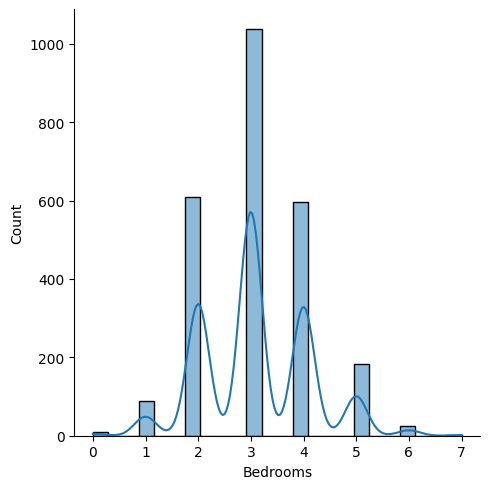

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     3.0|     3.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     2.0|     2.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
|     3.0|     3.0|
+--------+--------+
only showing top 20 rows



In [47]:
from pyspark.ml.feature import Bucketizer

# Plot distribution of sample_df
sns.displot(sample_df['Bedrooms'], kde=True)
plt.xlabel('Bedrooms')
plt.show()

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='Bedrooms', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['BEDROOMS', 'bedrooms']].show()

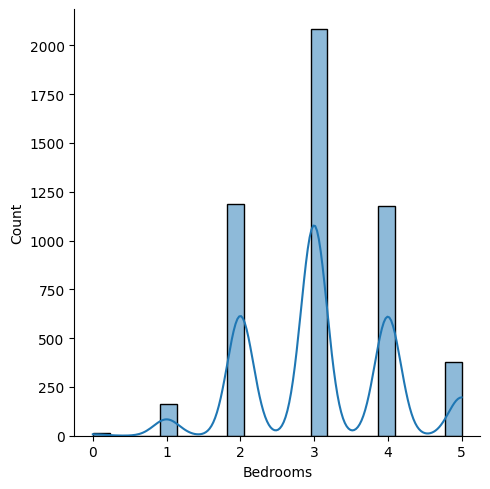

In [50]:
sns.displot(df_bucket.toPandas()['bedrooms'], kde=True)
plt.xlabel('Bedrooms')
plt.show()

In [62]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SchoolDistrictNumber', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SchoolDistrictNumber', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SchoolDistrictNumber|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]